In [1]:
!pip install pyspark
!pip install geopandas
!pip install contextily

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=888847ef6ef8b256b8153ac56c731f2e309bda86530cf09b2852b1349253d7c6
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 72.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd
import matplotlib.pyplot as plt
spark = SparkSession.builder.appName('DB_Final_Project').getOrCreate()

In [3]:
spark

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
taxi= spark.read\
      .option("header", "true")\
      .option("inferSchema", "true")\
      .parquet("/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-01.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-02.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-03.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-04.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-05.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-06.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-07.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-08.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-09.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-10.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-11.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-12.parquet")

In [6]:
#taxi.printSchema()

In [7]:
#taxi.count()

In [8]:
taxi=taxi.na.drop(how="any")

In [9]:
#filter->select * where...
taxi=taxi.filter(year(col("tpep_pickup_datetime"))=="2022")

In [10]:
taxi=taxi.distinct()

In [11]:
#sort->order by
taxi.sort("tpep_pickup_datetime").show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2022-01-01 00:00:08|  2022-01-01 00:14:14|            1.0|         7.94|       1.0|                 N|         138|         255|           1|       23.0|  0.5|    0.5|      4.8

In [12]:
#date can be changed here
date="2022-"+input("What date do you want to know? enter in type mm-dd: ")
pickup_by_day=taxi.filter(col("tpep_pickup_datetime").startswith(date))
#pickup_by_day.show(5)

What date do you want to know? enter in type mm-dd: 06-24


In [13]:
#alias->name as
pbd_hour=pickup_by_day.select(hour(col("tpep_pickup_datetime")).alias("hour")).groupby("hour").count()
            

In [14]:
#pbd_hour.show(24)

In [15]:
#change from pyspark dataframe to pandas dataframe
pbd_hour_pd=pbd_hour.sort("hour").toPandas()

Most pickup hour:  18, having  8540  pickup counts.
Least pickup hour:  4, having   704  pickup counts.


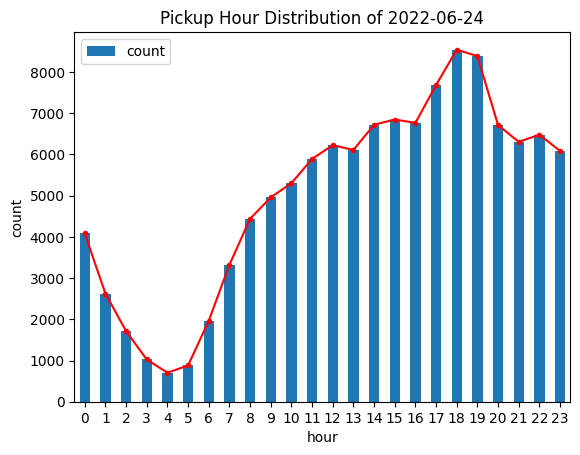

In [16]:
print("Most pickup hour: {:3d}, having {:5d}  pickup counts."
    .format(pbd_hour_pd['hour'].loc[pbd_hour_pd['count'].idxmax()],pbd_hour_pd["count"].max()))
print("Least pickup hour: {:2d}, having {:5d}  pickup counts."
    .format(pbd_hour_pd['hour'].loc[pbd_hour_pd['count'].idxmin()],pbd_hour_pd["count"].min()))
#pbd_hour_pd=pbd_hour_pd
pbd_hour_pd.plot.bar(x='hour', y='count')
plt.plot(pbd_hour_pd["hour"],pbd_hour_pd["count"],color="r",marker=".")
plt.title(f"Pickup Hour Distribution of {date}")
plt.xlabel("hour")
plt.ylabel("count")
plt.xticks(rotation=0)
plt.show()

In [17]:
#read location map data
import geopandas as gpd
shapefile_path = "/content/drive/MyDrive/yellow_tripdata_2022/taxi_zones.zip" 

gdf = gpd.read_file(shapefile_path)


In [18]:
#gdf

In [19]:
pbd_location=pickup_by_day.select(col("PULocationID").alias("LocationID")).groupBy("LocationID").count()
#pbd_location.sort("LocationID").show(5)

In [20]:
pbd_location_pd=pbd_location.toPandas()

In [21]:
#left join gdf and pbd_location_pd
gdf_location = gdf.merge(pbd_location_pd, on='LocationID', suffixes=('', '_count'),how="left")
gdf_location['count'] = gdf_location['count'].fillna(0)

Most pickup zone:  JFK Airport  in  Queens  borough, having 5552.0  pickups.


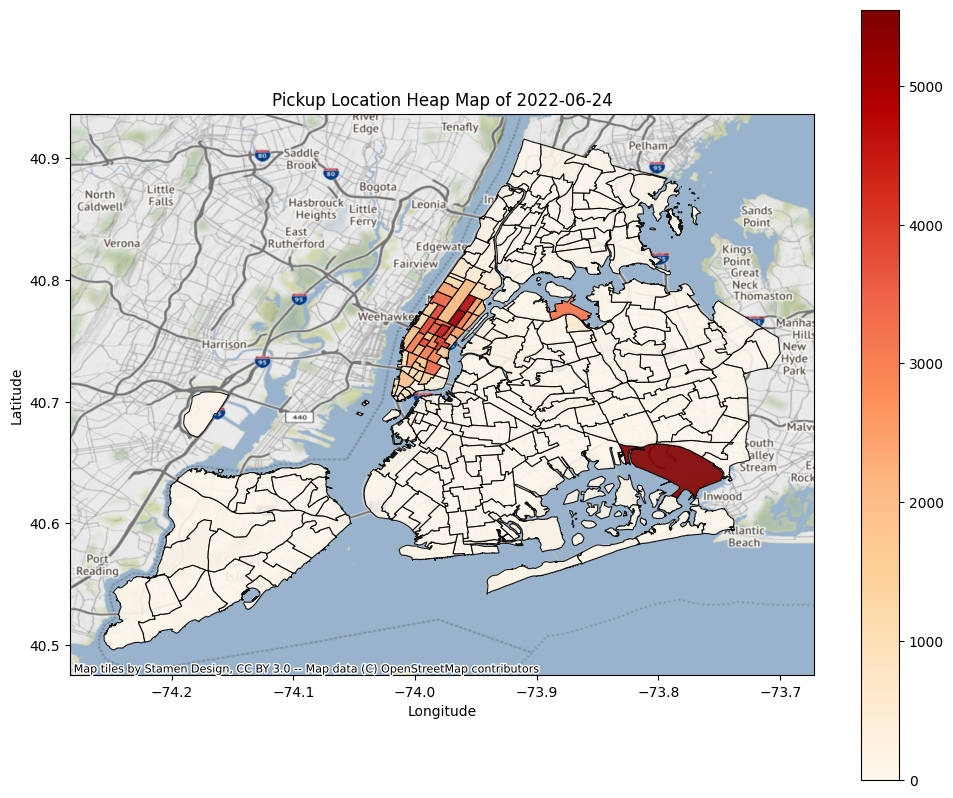

In [24]:
print("Most pickup zone: ",gdf_location['zone'].loc[gdf_location['count'].idxmax()],
      " in ",gdf_location['borough'].loc[gdf_location['count'].idxmax()],
      f" borough, having {gdf_location['count'].max()}  pickups.")
gdf_location=gdf_location.to_crs(epsg=4326)
import contextily as cx
fig, ax = plt.subplots(figsize=(12, 10))
#plot heap map of pickups
gdf_location.plot(column='count', cmap='OrRd', linewidth=0.8, 
        ax=ax, edgecolor='k', alpha=0.9,legend=True)
#add NYC borough as basemap 
cx.add_basemap(ax,crs=gdf_location.crs)
ax.set_title(f'Pickup Location Heap Map of {date}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

Most dropoff zone:  Upper East Side North  in  Manhattan  borough, having 4402.0  dropoffs.


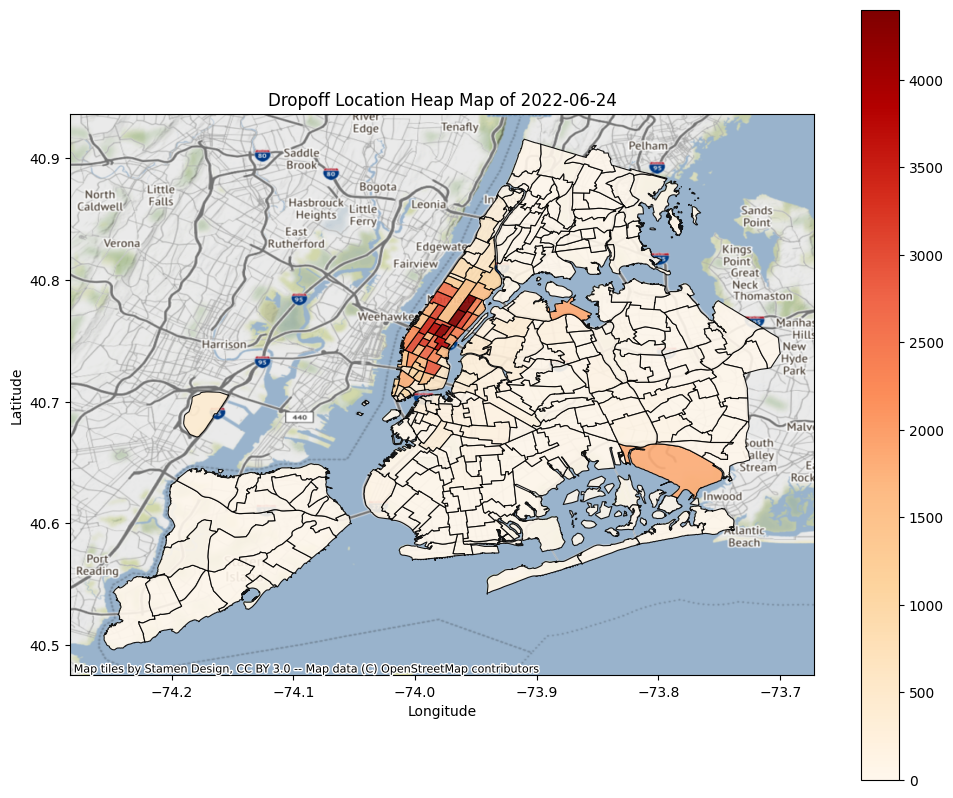

In [25]:
pbd_dolocation=pickup_by_day.select(col("DOLocationID").alias("LocationID")).groupBy("LocationID").count()
pbd_dolocation_pd=pbd_dolocation.toPandas()
gdf_dolocation = gdf.merge(pbd_dolocation_pd, on='LocationID', suffixes=('', '_count'),how="left")
gdf_dolocation['count'] = gdf_dolocation['count'].fillna(0)
print("Most dropoff zone: ",gdf_dolocation['zone'].loc[gdf_dolocation['count'].idxmax()],
      " in ",gdf_dolocation['borough'].loc[gdf_dolocation['count'].idxmax()],
      f" borough, having {gdf_dolocation['count'].max()}  dropoffs.")
gdf_dolocation=gdf_dolocation.to_crs(epsg=4326)
fig, ax = plt.subplots(figsize=(12, 10))
gdf_dolocation.plot(column='count', cmap='OrRd', linewidth=0.8, 
        ax=ax, edgecolor='k', alpha=0.9,legend=True)

cx.add_basemap(ax,crs=gdf_dolocation.crs)
ax.set_title(f'Dropoff Location Heap Map of {date}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()